In [1]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, TargetEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
df = pd.read_pickle('../data/clean_data.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1437 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   battery_power  1437 non-null   int64   
 1   blue           1437 non-null   category
 2   clock_speed    1437 non-null   float16 
 3   dual_sim       1437 non-null   category
 4   fc             1437 non-null   int8    
 5   four_g         1437 non-null   category
 6   int_memory     1437 non-null   int8    
 7   m_dep          1437 non-null   float16 
 8   mobile_wt      1437 non-null   int64   
 9   n_cores        1437 non-null   int8    
 10  pc             1437 non-null   int8    
 11  px_height      1437 non-null   int64   
 12  px_width       1437 non-null   int64   
 13  ram            1437 non-null   int64   
 14  sc_h           1437 non-null   int8    
 15  sc_w           1437 non-null   int8    
 16  talk_time      1437 non-null   int8    
 17  three_g        1437 non-null   categor

In [4]:
df = df.rename(columns={'price_range': 'target'})

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=2)

In [6]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()
cat_features

['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

In [7]:
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
num_features

['battery_power',
 'clock_speed',
 'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
 'px_height',
 'px_width',
 'ram',
 'sc_h',
 'sc_w',
 'talk_time']

In [8]:
s_scaler = StandardScaler()
l_encoder = TargetEncoder() 
classifier = RandomForestClassifier()

In [9]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [10]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model', RandomForestClassifier())])

In [11]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics

{'precision': 0.8489667203435319,
 'recall': 0.8472222222222222,
 'f1': 0.84644501611656}

In [12]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri) 

In [13]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "estate_project"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

In [14]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [15]:
# Будем логировать requirements и артефакт - текстовый файл
req_file = '../requirements.txt'

In [16]:
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
#params_dict = {'n_estimators': 10, 'max_depth': 10}
params_dict = pipeline.get_params()

In [17]:
# Когда создаем новый эксперимент, то: 
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/11/18 22:37:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/bfa7ab0f0c424f97aa23d51811088a87.
2024/11/18 22:37:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [18]:
mlflow.sklearn.autolog()

with mlflow.start_run(run_name='auto', experiment_id=experiment_id) as run:
    pipeline.fit(X_train, y_train)

2024/11/18 22:37:34 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2024/11/18 22:37:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (flo

In [19]:
mlflow.sklearn.autolog(disable=True)

In [20]:
classifier2 = RandomForestClassifier(n_estimators=10, max_depth=6)

In [21]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier2)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('model',
                 RandomForestClassifier(max_depth=6, n_estimators=10))])

In [22]:
predictions = pipeline.predict(X_test) 

metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics

{'precision': 0.7937849917354125,
 'recall': 0.7861111111111111,
 'f1': 0.7826538410628452}

In [23]:
# !!! Проверить название прогона а также все логируемые параметры и артефакты, что они соответствуют второй "маленькой" модели. 

RUN_NAME = 'smaller_model'

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 22:37:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run smaller_model at: http://127.0.0.1:5000/#/experiments/1/runs/8fbdb00c90814d8488c8bec75eab7443.
2024/11/18 22:37:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [24]:
# No model
# Логировать можно только артефакты, без модели. Например, залогироавть графики после этапа EDA

RUN_NAME = 'no_model'
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id 


run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 22:37:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run no_model at: http://127.0.0.1:5000/#/experiments/1/runs/76f2bd9f3d5743c2a5ce0ceba597d319.
2024/11/18 22:37:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [25]:
# Можно регистрировать сразу при создании прогона

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name='register_at_run', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME # Указываем для какой модели регистрируем
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Successfully registered model 'estate_model_rf'.
2024/11/18 22:37:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 1
Created version '1' of model 'estate_model_rf'.
2024/11/18 22:37:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run register_at_run at: http://127.0.0.1:5000/#/experiments/1/runs/af6d2b44e61d4faf9ae8f13e0b2cd141.
2024/11/18 22:37:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [26]:
model_name = REGISTRY_MODEL_NAME
model_version = 1

model_loaded = mlflow.sklearn.load_model(model_uri=f"models:/{model_name}/{model_version}")

In [27]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler

In [28]:
X_train_sklearn = X_train.copy()

In [29]:
pf = PolynomialFeatures(degree=2)

In [30]:
X_train_sklearn

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1741,946,1,1.400391,0,9,0,26,0.099976,186,6,10,273,891,1637,7,3,6,1,0,1
232,1715,0,1.000000,1,4,1,31,0.500000,83,8,17,638,1615,625,17,6,13,1,0,0
1675,1630,1,2.800781,1,0,1,32,0.899902,80,6,1,712,1726,1751,12,10,20,1,0,1
470,752,0,0.500000,1,1,0,48,0.700195,87,7,13,164,728,3860,7,5,16,0,0,0
1915,936,0,1.000000,0,1,0,18,0.199951,153,3,18,1330,1686,2391,12,6,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,666,1,0.500000,1,7,1,54,0.399902,81,3,13,58,1353,1254,15,9,9,1,1,1
426,1190,1,2.199219,1,9,0,47,0.300049,186,6,10,1417,1441,624,9,3,19,1,1,1
690,1403,0,2.699219,0,2,1,26,0.099976,164,5,3,461,1251,3371,13,9,9,1,0,1
736,503,0,2.500000,0,3,0,57,0.600098,185,6,11,778,1291,305,11,8,16,0,0,1


In [31]:
pf.fit_transform(X_train_sklearn[['m_dep','battery_power']])

array([[1.00000000e+00, 9.99755859e-02, 9.46000000e+02, 9.99511778e-03,
        9.45769043e+01, 8.94916000e+05],
       [1.00000000e+00, 5.00000000e-01, 1.71500000e+03, 2.50000000e-01,
        8.57500000e+02, 2.94122500e+06],
       [1.00000000e+00, 8.99902344e-01, 1.63000000e+03, 8.09824228e-01,
        1.46684082e+03, 2.65690000e+06],
       ...,
       [1.00000000e+00, 9.99755859e-02, 1.40300000e+03, 9.99511778e-03,
        1.40265747e+02, 1.96840900e+06],
       [1.00000000e+00, 6.00097656e-01, 5.03000000e+02, 3.60117197e-01,
        3.01849121e+02, 2.53009000e+05],
       [1.00000000e+00, 1.99951172e-01, 7.70000000e+02, 3.99804711e-02,
        1.53962402e+02, 5.92900000e+05]])

In [32]:
sp = SplineTransformer(n_knots=3, degree=3)

In [33]:
sp.fit_transform(X_train_sklearn[['px_height']])

array([[0.06690626, 0.60688358, 0.32320198, 0.00300818, 0.        ],
       [0.00772773, 0.38764177, 0.56078677, 0.04384373, 0.        ],
       [0.00375873, 0.33656692, 0.59811978, 0.06155457, 0.        ],
       ...,
       [0.02664969, 0.50540044, 0.45201833, 0.01593154, 0.        ],
       [0.00163569, 0.2917294 , 0.6257347 , 0.08090021, 0.        ],
       [0.01031397, 0.41172227, 0.5411553 , 0.03680847, 0.        ]])

In [34]:
qt = QuantileTransformer()

In [35]:
qt.fit_transform(X_train_sklearn[['px_height']])

array([[0.22872873],
       [0.54554555],
       [0.60047141],
       ...,
       [0.4034034 ],
       [0.64314314],
       [0.51588829]])

In [36]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
sp = SplineTransformer(n_knots=3, degree=3)

In [37]:
pf_pipeline = Pipeline(steps=[
    ('poly', pf),
    ('scale', StandardScaler())
])

In [38]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,num_features),
        ('poly', pf_pipeline, ['m_dep', 'battery_power']), # В преобразования добавляем созданный ранее pipeline
        ('spline', sp, ['px_height'])
    ],
    remainder='drop',
    ) # Удаляем столбцы, которые не затронуты преобразования

In [39]:
X_train_sklearn[['m_dep', 'battery_power']] = X_train_sklearn[['m_dep', 'battery_power']].astype('float64')
X_train_sklearn[['m_dep', 'battery_power']] = X_train_sklearn[['m_dep', 'battery_power']].astype('float64')

In [40]:
X_train_sklearn

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1741,946.0,1,1.400391,0,9,0,26,0.099976,186,6,10,273,891,1637,7,3,6,1,0,1
232,1715.0,0,1.000000,1,4,1,31,0.500000,83,8,17,638,1615,625,17,6,13,1,0,0
1675,1630.0,1,2.800781,1,0,1,32,0.899902,80,6,1,712,1726,1751,12,10,20,1,0,1
470,752.0,0,0.500000,1,1,0,48,0.700195,87,7,13,164,728,3860,7,5,16,0,0,0
1915,936.0,0,1.000000,0,1,0,18,0.199951,153,3,18,1330,1686,2391,12,6,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,666.0,1,0.500000,1,7,1,54,0.399902,81,3,13,58,1353,1254,15,9,9,1,1,1
426,1190.0,1,2.199219,1,9,0,47,0.300049,186,6,10,1417,1441,624,9,3,19,1,1,1
690,1403.0,0,2.699219,0,2,1,26,0.099976,164,5,3,461,1251,3371,13,9,9,1,0,1
736,503.0,0,2.500000,0,3,0,57,0.600098,185,6,11,778,1291,305,11,8,16,0,0,1


In [41]:
X_train_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_sklearn, y_train)


In [42]:
X_train_sklearn = pd.DataFrame(X_train_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

In [43]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_sklearn)

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,num__ram,num__sc_h,num__sc_w,num__talk_time,cat__blue_0,cat__blue_1,cat__blue_2,cat__blue_3,cat__dual_sim_0,cat__dual_sim_1,cat__dual_sim_2,cat__dual_sim_3,cat__four_g_0,cat__four_g_1,cat__four_g_2,cat__four_g_3,cat__three_g_0,cat__three_g_1,cat__three_g_2,cat__three_g_3,cat__touch_screen_0,cat__touch_screen_1,cat__touch_screen_2,cat__touch_screen_3,cat__wifi_0,cat__wifi_1,cat__wifi_2,cat__wifi_3,quantile__battery_power,quantile__clock_speed,quantile__fc,quantile__int_memory,quantile__m_dep,quantile__mobile_wt,quantile__n_cores,quantile__pc,quantile__px_height,quantile__px_width,quantile__ram,quantile__sc_h,quantile__sc_w,quantile__talk_time,poly__1,poly__m_dep,poly__battery_power,poly__m_dep^2,poly__m_dep battery_power,poly__battery_power^2,spline__px_height_sp_0,spline__px_height_sp_1,spline__px_height_sp_2,spline__px_height_sp_3,spline__px_height_sp_4
0,-0.656113,-0.138190,1.093728,-0.372868,-1.375675,1.246637,0.620719,0.046466,-0.870069,-0.861281,-0.454690,-1.458894,-1.201724,-0.912773,0.267601,0.221439,0.245781,0.265174,0.252846,0.227803,0.275596,0.243754,0.256088,0.231712,0.275577,0.236621,0.252712,0.231012,0.269756,0.246520,0.248236,0.234041,0.271845,0.245877,0.255699,0.244267,0.239775,0.260255,0.318318,0.462462,0.839840,0.389890,0.000000,0.868869,0.674174,0.526026,0.228729,0.258258,0.362454,0.094595,0.000000,0.234735,0.0,-1.375675,-0.656113,-1.052531,-1.184632,-0.742832,0.066906,0.606884,0.323202,0.003008,0.0
1,1.107839,-0.631921,-0.062934,-0.099164,0.000693,-1.615754,1.496885,1.218069,-0.051504,0.806629,-1.381706,1.020950,-0.392308,0.359910,0.254074,0.226126,0.275027,0.244771,0.240027,0.242334,0.251789,0.265848,0.249453,0.242806,0.245069,0.262668,0.251136,0.225429,0.269278,0.254157,0.251781,0.237522,0.258915,0.251781,0.244569,0.230035,0.280825,0.244569,0.824324,0.359359,0.580080,0.473974,0.507007,0.031031,1.000000,0.856857,0.545546,0.724725,0.110595,0.804805,0.432432,0.600601,0.0,0.000693,1.107839,-0.273520,0.539330,1.126755,0.007728,0.387642,0.560787,0.043844,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,-1.672278,1.217764,-0.294267,1.324097,0.345101,1.218847,0.620719,0.213838,0.262466,0.060216,-1.674833,-0.466957,0.147303,0.905345,0.255071,0.241518,0.273115,0.230292,0.266169,0.229178,0.268506,0.236143,0.237896,0.230592,0.279087,0.252423,0.248861,0.239607,0.235143,0.276371,0.242374,0.244681,0.270571,0.242372,0.261445,0.243099,0.238585,0.256866,0.002002,0.847347,0.507007,0.880380,0.601101,0.855856,0.674174,0.579580,0.643143,0.516016,0.011191,0.340841,0.607608,0.756757,0.0,0.345101,-1.672278,0.083899,-0.716263,-1.329303,0.001636,0.291729,0.625735,0.080900,0.0
1076,-1.059827,-0.015360,0.399731,1.543060,-1.031688,1.524539,-0.255447,-0.120906,-0.129996,0.502535,1.227130,-1.458894,-1.201724,-1.276396,0.249428,0.242475,0.249451,0.258644,0.240027,0.242334,0.251789,0.265848,0.254272,0.224961,0.281125,0.239637,0.253721,0.263524,0.238915,0.243820,0.251781,0.237522,0.258915,0.251781,0.258337,0.238298,0.245025,0.258337,0.187732,0.498999,0.700200,0.943944,0.215716,0.948448,0.408909,0.464965,0.515888,0.648854,0.850203,0.094595,0.000000,0.123624,0.0,-1.031688,-1.059827,-0.955204,-1.050439,-1.018765,0.010314,0.411722,0.541155,0.036808,0.0


In [44]:
pipeline_sklearn = Pipeline(steps=[
    ('transform', preprocessor_sklearn),
    ('model', classifier)
])

model_sklearn = pipeline_sklearn.fit(X_train, y_train)

In [45]:
model_sklearn


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('model', RandomForestClassifier())])

In [46]:
predictions = model_sklearn.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics

{'precision': 0.8752310884738728,
 'recall': 0.8694444444444445,
 'f1': 0.8700470139179817}

In [47]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'fe_sklearn'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(model_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(model_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 22:37:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run fe_sklearn at: http://127.0.0.1:5000/#/experiments/1/runs/1b4ae0bf0db141caaf520b114464e810.
2024/11/18 22:37:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [48]:
import numpy as np

In [49]:
import sys
sys.modules.keys()

dict_keys(['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', 'sitecustomize', 'site', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib._abc', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', 'types', '_functools', 'functools', 'contextlib', 'importlib.util', 'runpy', 'enum', '_sre', 'sre_constants', 'sre_parse', 'sre_compile', '_locale', 'copyreg', 're', 'fnmatch', 'ntpath', 'errno', 'urllib', 'urllib.parse', 'pathlib', 'collections.abc', 'typing.io', 'typing.re', 'typing', 'ipykernel._version', '__future__', '_json', 'json.scanner', 'json.decoder', 'json.

In [50]:
from autofeat import AutoFeatRegressor
transformations = ["1/", "exp", "log", "abs", "sqrt", "^2", "^3", "1+", "1-", "sin", "cos", "exp-", "2^"]

In [51]:
afreg = AutoFeatRegressor(verbose=1, feateng_steps=2, max_gb=8, transformations=["log", "sqrt"],feateng_cols=num_features)
X_train_arf = afreg.fit_transform(X_train,y_train)
X_train_arf

2024-11-18 22:37:49,265 INFO: [AutoFeat] The 2 step feature engineering process could generate up to 406 features.
2024-11-18 22:37:49,266 INFO: [AutoFeat] With 1077 data points this new feature matrix would use about 0.00 gb of space.
2024-11-18 22:37:49,269 INFO: [feateng] Step 1: transformation of original features


2024-11-18 22:37:51,159 INFO: [feateng] Generated 26 transformed features from 14 original features - done.
2024-11-18 22:37:51,168 INFO: [feateng] Step 2: first combination of features


2024-11-18 22:37:52,732 INFO: [feateng] Generated 780 feature combinations from 780 original feature tuples - done.
2024-11-18 22:37:52,746 INFO: [feateng] Generated altogether 808 new features in 2 steps
2024-11-18 22:37:52,747 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2024-11-18 22:37:52,784 INFO: [feateng] Generated a total of 559 additional features
2024-11-18 22:37:52,855 INFO: [featsel] Feature selection run 1/5


[featsel] Scaling data...done.


2024-11-18 22:38:02,970 INFO: [featsel] Feature selection run 2/5
2024-11-18 22:38:11,552 INFO: [featsel] Feature selection run 3/5
2024-11-18 22:38:21,748 INFO: [featsel] Feature selection run 4/5
2024-11-18 22:38:30,071 INFO: [featsel] Feature selection run 5/5
2024-11-18 22:38:41,044 INFO: [featsel] 77 features after 5 feature selection runs
/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:
2024-11-18 22:38:41,090 INFO: [featsel] 60 features after correlation filtering
2024-11-18 22:38:41,371 INFO: [featsel] 9 features after noise filtering
2024-11-18 22:38:41,374 INFO: [AutoFeat] Computing 6 new features.


2024-11-18 22:38:42,920 INFO: [AutoFeat]     6/    6 new features ...done.
2024-11-18 22:38:42,923 INFO: [AutoFeat] Final dataframe with 26 feature columns (6 new).
2024-11-18 22:38:42,924 INFO: [AutoFeat] Training final regression model.
2024-11-18 22:38:42,938 INFO: [AutoFeat] Trained model: largest coefficients:
2024-11-18 22:38:42,940 INFO: -2.4839521707907752
2024-11-18 22:38:42,941 INFO: 0.032799 * log(battery_power)*log(px_width)
2024-11-18 22:38:42,944 INFO: -0.001025 * mobile_wt
2024-11-18 22:38:42,948 INFO: 0.000807 * sqrt(battery_power)*log(px_height)
2024-11-18 22:38:42,949 INFO: 0.000804 * ram
2024-11-18 22:38:42,950 INFO: 0.000202 * px_height
2024-11-18 22:38:42,953 INFO: 0.000092 * sqrt(px_width)*sqrt(ram)
2024-11-18 22:38:42,968 INFO: [AutoFeat] Final score: 0.9160


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,talk_time,three_g,touch_screen,wifi,battery_power*sqrt(ram),sqrt(px_width)*sqrt(ram),ram*sc_h,log(battery_power)*log(px_width),sqrt(battery_power)*log(px_height),sqrt(int_memory)*ram
0,946.0,1.0,1.400391,0.0,9.0,0.0,26.0,0.099976,186.0,6.0,...,6.0,1.0,0.0,1.0,38275.024389,1207.711472,11459.0,46.542792,172.531158,8347.094944
1,1715.0,0.0,1.000000,1.0,4.0,1.0,31.0,0.500000,83.0,8.0,...,13.0,1.0,0.0,0.0,42875.000000,1004.676565,10625.0,55.012905,267.456312,3479.852727
2,1630.0,1.0,2.800781,1.0,0.0,1.0,32.0,0.899902,80.0,6.0,...,20.0,1.0,0.0,1.0,68207.271606,1738.455061,21012.0,55.129043,265.174707,9905.151791
3,752.0,0.0,0.500000,1.0,1.0,0.0,48.0,0.700195,87.0,7.0,...,16.0,0.0,0.0,0.0,46720.931498,1676.329323,27020.0,43.645826,139.851691,26742.864469
4,936.0,0.0,1.000000,0.0,1.0,0.0,18.0,0.199951,153.0,3.0,...,3.0,1.0,1.0,1.0,45768.390140,2007.791324,28692.0,50.833984,220.061472,10144.153883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,666.0,1.0,0.500000,1.0,7.0,1.0,54.0,0.399902,81.0,3.0,...,9.0,1.0,1.0,1.0,23584.300371,1302.559787,18810.0,46.874816,104.787755,9214.980412
1073,1190.0,1.0,2.199219,1.0,9.0,0.0,47.0,0.300049,186.0,6.0,...,19.0,1.0,1.0,1.0,29726.190472,948.253131,5616.0,51.505922,250.315962,4277.928471
1074,1403.0,0.0,2.699219,0.0,2.0,1.0,26.0,0.099976,164.0,5.0,...,9.0,1.0,0.0,1.0,81458.619796,2053.563001,43823.0,51.678912,229.736492,17188.794780
1075,503.0,0.0,2.500000,0.0,3.0,0.0,57.0,0.600098,185.0,6.0,...,16.0,0.0,0.0,1.0,8784.517346,627.499004,3355.0,44.559160,149.294809,2302.699503


In [52]:
class AutoFeatWrapper():
    def __init__(self, feateng_cols, feateng_steps=1, max_gb=16, transformations=["1/", "exp", "log"], n_jobs=-1, verbose=1):
        self.feateng_cols = feateng_cols
        self.feateng_steps = feateng_steps
        self.max_gb = max_gb
        self.transformations = transformations
        self.n_jobs = n_jobs
        self.afreg = AutoFeatRegressor(feateng_cols=self.feateng_cols,
                                     feateng_steps=self.feateng_steps,
                                     max_gb=self.max_gb,
                                     transformations=self.transformations,
                                     n_jobs=self.n_jobs)
        
    def fit(self, X, y=None):
        self.afreg.fit(X, y)
        return self
    
    def transform(self, X):
        return self.afreg.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        # Преобразуем данные и возвращаем имена фичей из DataFrame
        transformed_X = self.afreg.transform(pd.DataFrame(np.zeros((1, len(self.feateng_cols))), columns=self.feateng_cols))
        return transformed_X.columns.tolist()

In [53]:
afreg_pipeline = Pipeline(steps=[
    ('autofeat', AutoFeatWrapper( feateng_steps=2, max_gb=16, transformations=["log", "sqrt"],feateng_cols=num_features)),
    ('scaler', StandardScaler()),
])

In [54]:
preprocessor_afr = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', l_encoder, cat_features), # преобразования для категориальных признаков
        ('afr', afreg_pipeline, num_features), # преобразования autofeat
    ],
    remainder='drop', # Удаляем столбцы, которые не затронуты преобразованиями
    ) 

In [55]:
X_train_afr_raw =  preprocessor_afr.fit_transform(X_train,y_train)
X_train_afr = pd.DataFrame(X_train_afr_raw, columns=preprocessor_afr.get_feature_names_out())

/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


In [56]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display (X_train_afr)

    

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,num__ram,num__sc_h,num__sc_w,num__talk_time,cat__blue_0,cat__blue_1,cat__blue_2,cat__blue_3,cat__dual_sim_0,cat__dual_sim_1,cat__dual_sim_2,cat__dual_sim_3,cat__four_g_0,cat__four_g_1,cat__four_g_2,cat__four_g_3,cat__three_g_0,cat__three_g_1,cat__three_g_2,cat__three_g_3,cat__touch_screen_0,cat__touch_screen_1,cat__touch_screen_2,cat__touch_screen_3,cat__wifi_0,cat__wifi_1,cat__wifi_2,cat__wifi_3,afr__battery_power,afr__clock_speed,afr__fc,afr__int_memory,afr__m_dep,afr__mobile_wt,afr__n_cores,afr__pc,afr__px_height,afr__px_width,afr__ram,afr__sc_h,afr__sc_w,afr__talk_time,afr__battery_power*sqrt(ram),afr__sqrt(px_width)*sqrt(ram),afr__sqrt(battery_power)*log(px_height),afr__sqrt(n_cores)*ram,afr__battery_power*px_width,afr__battery_power*log(int_memory),afr__sqrt(px_width)*log(px_height)
0,-0.656113,-0.138190,1.093728,-0.372868,-1.375675,1.246637,0.620719,0.046466,-0.870069,-0.861281,-0.454690,-1.458894,-1.201724,-0.912773,0.251175,0.232399,0.265254,0.251172,0.251143,0.253379,0.258003,0.237472,0.254191,0.225440,0.273357,0.247011,0.253065,0.230068,0.271460,0.245407,0.249417,0.232944,0.268224,0.249414,0.256282,0.237978,0.256309,0.249431,-0.656113,-0.138190,1.093728,-0.372868,-1.375675,1.246637,0.620719,0.046466,-0.870069,-0.861281,-0.454690,-1.458894,-1.201724,-0.912773,-0.632932,-0.636390,-0.815446,-0.140137,-0.903025,-0.517747,-0.875874
1,1.107839,-0.631921,-0.062934,-0.099164,0.000693,-1.615754,1.496885,1.218069,-0.051504,0.806629,-1.381706,1.020950,-0.392308,0.359910,0.245507,0.234232,0.272502,0.247757,0.256518,0.232781,0.242328,0.268368,0.257129,0.235161,0.257157,0.250553,0.249247,0.229613,0.276415,0.244724,0.245296,0.226431,0.271208,0.257063,0.250002,0.224078,0.285324,0.240592,1.107839,-0.631921,-0.062934,-0.099164,0.000693,-1.615754,1.496885,1.218069,-0.051504,0.806629,-1.381706,1.020950,-0.392308,0.359910,-0.454647,-1.015053,1.064001,-0.992945,1.522828,1.062827,0.690310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,-1.672278,1.217764,-0.294267,1.324097,0.345101,1.218847,0.620719,0.213838,0.262466,0.060216,-1.674833,-0.466957,0.147303,0.905345,0.245507,0.234232,0.272502,0.247757,0.245467,0.234089,0.284042,0.236398,0.243859,0.231532,0.270918,0.253690,0.256254,0.246165,0.221294,0.276253,0.245296,0.226431,0.271208,0.257063,0.251714,0.242542,0.242608,0.263132,-1.672278,1.217764,-0.294267,1.324097,0.345101,1.218847,0.620719,0.213838,0.262466,0.060216,-1.674833,-0.466957,0.147303,0.905345,-1.775917,-1.718494,-1.275508,-1.381178,-1.146654,-1.108115,0.344049
1076,-1.059827,-0.015360,0.399731,1.543060,-1.031688,1.524539,-0.255447,-0.120906,-0.129996,0.502535,1.227130,-1.458894,-1.201724,-1.276396,0.255212,0.229709,0.257551,0.257527,0.243578,0.236529,0.257622,0.262270,0.242740,0.237855,0.288766,0.230631,0.244166,0.258097,0.239537,0.258185,0.251164,0.234882,0.265109,0.248844,0.258565,0.244827,0.249456,0.247150,-1.059827,-0.015360,0.399731,1.543060,-1.031688,1.524539,-0.255447,-0.120906,-0.129996,0.502535,1.227130,-1.458894,-1.201724,-1.276396,-0.357646,1.343789,-0.714176,0.976700,-0.526560,-0.470893,0.469151


In [57]:
pipeline_afr = Pipeline(steps=[('preprocessor', preprocessor_afr), 
                               ('model', classifier)])

pipeline_afr.fit(X_train, y_train)

/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('afr',
                                                  Pipeline(steps=[('autofeat',
                                                                   <__main__.AutoFeatWrapper object at 0x7eb07db5feb0>),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time'])])),
                ('model', RandomForestClassifier())])

In [58]:
X_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1791,1203,1,0.500000,1,0,1,11,0.899902,109,2,12,35,510,1672,17,13,19,1,1,0
192,1490,1,0.500000,1,4,1,64,0.300049,150,8,8,1417,1464,3600,17,9,7,1,1,1
1515,595,0,2.599609,0,0,1,20,0.399902,122,2,18,623,816,1593,19,11,2,1,0,1
1776,1072,1,2.199219,1,6,0,19,0.399902,114,8,16,380,877,2715,15,9,16,0,1,0
781,1368,0,3.000000,1,10,0,50,0.199951,97,7,18,698,829,2496,13,6,5,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1137,1,1.000000,0,18,0,7,1.000000,196,3,19,942,1179,3616,13,5,12,1,1,1
984,1261,1,0.500000,1,0,1,11,0.199951,90,4,0,858,1591,348,14,9,14,1,0,1
517,1059,0,2.400391,0,8,0,61,0.099976,134,3,18,1613,1916,3716,15,13,11,1,1,0
1567,940,0,2.900391,0,0,0,16,0.700195,115,4,1,499,1090,2192,15,13,9,1,1,1


In [59]:
predictions = pipeline_afr.predict(X_test) 
metrics = {}
metrics["precision"] = precision_score(y_test, predictions, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions, average='weighted')

metrics

{'precision': 0.9049063662435755,
 'recall': 0.9027777777777778,
 'f1': 0.903407965288304}

In [60]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name='autofeat', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline_afr, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(pipeline_afr.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 22:39:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run autofeat at: http://127.0.0.1:5000/#/experiments/1/runs/c07dfee2baee411f81e7d394f6de8d70.
2024/11/18 22:39:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [61]:
from sklearn.feature_selection import RFE
X_train_afr

,num__battery_power,num__clock_speed,num__fc,num__int_memory,num__m_dep,num__mobile_wt,num__n_cores,num__pc,num__px_height,num__px_width,...,afr__sc_h,afr__sc_w,afr__talk_time,afr__battery_power*sqrt(ram),afr__sqrt(px_width)*sqrt(ram),afr__sqrt(battery_power)*log(px_height),afr__sqrt(n_cores)*ram,afr__battery_power*px_width,afr__battery_power*log(int_memory),afr__sqrt(px_width)*log(px_height)
0,-0.656113,-0.138190,1.093728,-0.372868,-1.375675,1.246637,0.620719,0.046466,-0.870069,-0.861281,...,-1.458894,-1.201724,-0.912773,-0.632932,-0.636390,-0.815446,-0.140137,-0.903025,-0.517747,-0.875874
1,1.107839,-0.631921,-0.062934,-0.099164,0.000693,-1.615754,1.496885,1.218069,-0.051504,0.806629,...,1.020950,-0.392308,0.359910,-0.454647,-1.015053,1.064001,-0.992945,1.522828,1.062827,0.690310
2,0.912864,1.588664,-0.988265,-0.044423,1.376642,-1.699124,0.620719,-1.459880,0.114452,1.062344,...,-0.218972,0.686914,1.632592,0.527174,0.353453,1.018827,-0.033922,1.577789,0.927615,0.916990
3,-1.101115,-1.248483,-0.756932,0.831430,0.689508,-1.504593,1.058802,0.548582,-1.114517,-1.236791,...,-1.458894,-0.662113,0.905345,-0.305587,0.237588,-1.462475,2.219217,-1.274966,-0.614039,-1.383283
4,-0.679051,-0.631921,-0.756932,-0.810794,-1.031688,0.329560,-0.693530,1.385441,1.500406,0.970194,...,-0.218972,-0.392308,-1.458208,-0.342506,0.855769,0.125619,-0.090111,0.022590,-0.729891,1.299209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,-1.298384,-1.248483,0.631063,1.159875,-0.343714,-1.671334,-0.693530,0.548582,-1.352238,0.203048,...,0.524981,0.417109,-0.367337,-1.202311,-0.459497,-2.156714,-0.839190,-0.829737,-0.757326,-1.183406
1073,-0.096420,0.846863,1.093728,0.776689,-0.687281,1.246637,0.620719,0.046466,1.695517,0.405777,...,-0.962926,-1.201724,1.450780,-0.964265,-1.120283,0.724635,-1.083962,0.194685,0.326566,0.960878
1074,0.392165,1.463425,-0.525600,-0.372868,-1.375675,0.635252,0.182636,-1.125136,-0.448452,-0.031934,...,0.029012,0.417109,-0.367337,1.040767,0.941134,0.317177,1.201797,0.245501,0.320617,-0.034217
1075,-1.672278,1.217764,-0.294267,1.324097,0.345101,1.218847,0.620719,0.213838,0.262466,0.060216,...,-0.466957,0.147303,0.905345,-1.775917,-1.718494,-1.275508,-1.381178,-1.146654,-1.108115,0.344049


In [62]:
rfe_selector = RFE(estimator=classifier, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_rfe = rfe_selector.fit_transform(X_train_afr,y_train)

In [63]:
X_train_afr_rfe = pd.DataFrame(X_train_rfe, columns=rfe_selector.get_feature_names_out())
X_train_afr_rfe

,num__battery_power,num__ram,afr__battery_power,afr__px_height,afr__ram,afr__battery_power*sqrt(ram),afr__sqrt(px_width)*sqrt(ram),afr__sqrt(battery_power)*log(px_height),afr__sqrt(n_cores)*ram,afr__battery_power*px_width,afr__battery_power*log(int_memory),afr__sqrt(px_width)*log(px_height)
0,-0.656113,-0.454690,-0.656113,-0.870069,-0.454690,-0.632932,-0.636390,-0.815446,-0.140137,-0.903025,-0.517747,-0.875874
1,1.107839,-1.381706,1.107839,-0.051504,-1.381706,-0.454647,-1.015053,1.064001,-0.992945,1.522828,1.062827,0.690310
2,0.912864,-0.350263,0.912864,0.114452,-0.350263,0.527174,0.353453,1.018827,-0.033922,1.577789,0.927615,0.916990
3,-1.101115,1.581631,-1.101115,-1.114517,1.581631,-0.305587,0.237588,-1.462475,2.219217,-1.274966,-0.614039,-1.383283
4,-0.679051,0.235992,-0.679051,1.500406,0.235992,-0.342506,0.855769,0.125619,-0.090111,0.022590,-0.729891,1.299209
...,...,...,...,...,...,...,...,...,...,...,...,...
1072,-1.298384,-0.805527,-1.298384,-1.352238,-0.805527,-1.202311,-0.459497,-2.156714,-0.839190,-0.829737,-0.757326,-1.183406
1073,-0.096420,-1.382622,-0.096420,1.695517,-1.382622,-0.964265,-1.120283,0.724635,-1.083962,0.194685,0.326566,0.960878
1074,0.392165,1.133695,0.392165,-0.448452,1.133695,1.040767,0.941134,0.317177,1.201797,0.245501,0.320617,-0.034217
1075,-1.672278,-1.674833,-1.672278,0.262466,-1.674833,-1.775917,-1.718494,-1.275508,-1.381178,-1.146654,-1.108115,0.344049


In [64]:
rfe_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_afr), 
    ('rfe_extractor', RFE(estimator=classifier, n_features_to_select=12, step = 0.2)),
    ('model', classifier)
])

rfe_pipeline.fit(X_train, y_train)

/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('afr',
                                                  Pipeline(steps=[('autofeat',
                                                                   <__main__.AutoFeatWrapper object at 0x7eb07db5feb0>),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time'])])),
                ('rfe_extractor',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=12, step=0.2)),
                ('model', RandomForestClassifier())])

In [65]:
predictions_rfe = rfe_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_rfe, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_rfe, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_rfe, average='weighted')

metrics

{'precision': 0.9247977623211014, 'recall': 0.925, 'f1': 0.9248309911215962}

In [66]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(rfe_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 22:39:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/f1d6a0476f8348a1b033b0d1967a80e5.
2024/11/18 22:39:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [67]:
rfe_skl_selector = RFE(estimator=classifier, n_features_to_select=12, step = 0.2) #drop 20% of features each iteration
X_train_skl_rfe = rfe_skl_selector.fit_transform(X_train_sklearn,y_train)

In [68]:
X_train_skl_rfe = pd.DataFrame(X_train_skl_rfe, columns=rfe_skl_selector.get_feature_names_out())
X_train_skl_rfe

,num__battery_power,num__px_height,num__px_width,num__ram,quantile__battery_power,quantile__px_height,quantile__px_width,quantile__ram,poly__battery_power,poly__battery_power^2,spline__px_height_sp_1,spline__px_height_sp_3
0,-0.656113,-0.870069,-0.861281,-0.454690,0.318318,0.228729,0.258258,0.362454,-0.656113,-0.742832,0.606884,0.003008
1,1.107839,-0.051504,0.806629,-1.381706,0.824324,0.545546,0.724725,0.110595,1.107839,1.126755,0.387642,0.043844
2,0.912864,0.114452,1.062344,-0.350263,0.767710,0.600471,0.806306,0.388571,0.912864,0.866985,0.336567,0.061555
3,-1.101115,-1.114517,-1.236791,1.581631,0.178592,0.120818,0.146146,0.959039,-1.101115,-1.043795,0.646040,0.000555
4,-0.679051,1.500406,0.970194,0.235992,0.315315,0.907177,0.778278,0.572491,-0.679051,-0.760026,0.044057,0.386952
...,...,...,...,...,...,...,...,...,...,...,...,...
1072,-1.298384,-1.352238,0.203048,-0.805527,0.119989,0.025025,0.552553,0.269517,-1.298384,-1.155211,0.665145,0.000010
1073,-0.096420,1.695517,0.405777,-1.382622,0.484484,0.931629,0.622623,0.109109,-0.096420,-0.266658,0.027969,0.446332
1074,0.392165,-0.448452,-0.031934,1.133695,0.602603,0.403403,0.489936,0.822732,0.392165,0.237953,0.505400,0.015932
1075,-1.672278,0.262466,0.060216,-1.674833,0.002002,0.643143,0.516016,0.011191,-1.672278,-1.329303,0.291729,0.080900


In [69]:
rfe_cols = X_train_skl_rfe.columns.tolist()
rfe_cols

['num__battery_power',
 'num__px_height',
 'num__px_width',
 'num__ram',
 'quantile__battery_power',
 'quantile__px_height',
 'quantile__px_width',
 'quantile__ram',
 'poly__battery_power',
 'poly__battery_power^2',
 'spline__px_height_sp_1',
 'spline__px_height_sp_3']

In [70]:
rfe_idx = rfe_skl_selector.support_
rfe_idx

array([ True, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
        True, False, False,  True, False,  True, False,  True, False])

In [71]:
with open('rfe_skl_idx.txt', 'w+') as f:
    f.write(str(rfe_idx))
with open('rfe_skl_cols.txt', 'w+') as f:
    f.write(str(rfe_cols))

In [72]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [73]:
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier)
])

rfe_skl_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7eb0ccd3d900>),
                ('model', RandomForestClassifier())])

In [74]:
predictions_rfe_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_rfe_skl, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_rfe_skl, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_rfe_skl, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(rfe_skl_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 22:39:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_skl_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/130eb45114e14284b0d67df44e8724bf.
2024/11/18 22:39:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [75]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [76]:
import sklearn

In [77]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=3), 
                                k_features=3,
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='f1_weighted',
                                cv=2)

sfs.fit(X_train_sklearn,y_train)

/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=3),
                          k_features=(3, 3), scoring='f1_weighted')

In [78]:
selected_features_sfs = X_train_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,quantile__battery_power,quantile__ram,spline__px_height_sp_3
0,0.318318,0.362454,0.003008
1,0.824324,0.110595,0.043844
2,0.767710,0.388571,0.061555
3,0.178592,0.959039,0.000555
4,0.315315,0.572491,0.386952
...,...,...,...
1072,0.119989,0.269517,0.000010
1073,0.484484,0.109109,0.446332
1074,0.602603,0.822732,0.015932
1075,0.002002,0.011191,0.080900


In [79]:
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['quantile__battery_power', 'quantile__ram', 'spline__px_height_sp_3']

In [80]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx

[38, 48, 61]

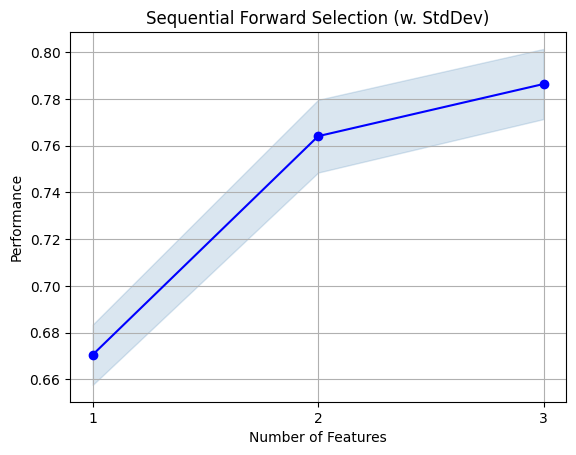

In [81]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [82]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', classifier)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7eb07c41e800>),
                ('model', RandomForestClassifier())])

In [83]:
predictions_sfs = rfe_sfs_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_sfs, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_sfs, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_sfs, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(rfe_sfs_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/11/18 22:40:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_sfs_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/a391b34a5d434d02befb95f3f45466a7.
2024/11/18 22:40:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [84]:
from sklearn.model_selection import  GridSearchCV

In [85]:
param_grid = {
    'model__max_depth': [i for i in range(1,10)],
    'model__n_estimators': [i for i in range(1,5)],
    'model__max_features': [i/10 for i in range(1,10)]
}

In [86]:
gs = GridSearchCV(rfe_skl_pipeline, param_grid, cv=2, scoring='f1_weighted')
gs.fit(X_train, y_train)
print("Лучшие гиперпараметры:", gs.best_params_)

/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (538). n_quantiles is set to n_samples.
  warnings.warn(
/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (539). n_quantiles is set to n_samples.
  warnings.warn(
/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (538). n_quantiles is set to n_samples.
  warnings.warn(
/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (539). n_quantiles is set to n_samples.
 

Лучшие гиперпараметры: {'model__max_depth': 9, 'model__max_features': 0.7, 'model__n_estimators': 4}


In [87]:
classifier_optimized = RandomForestClassifier(max_depth=7, max_features=0.8, n_estimators=4)
rfe_skl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_idx)),
    ('model', classifier_optimized)
])

rfe_skl_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7eb07c6620e0>),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features=0.8,
                                        n_estimators=4))])

In [88]:
predictions_skl = rfe_skl_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_skl, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_skl, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_skl, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_skl_feature_selection_optimased_GridSearch'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME # Указываем для какой модели регистрируем
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(rfe_skl_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'estate_model_rf' already exists. Creating a new version of this model...
2024/11/18 22:41:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 2
Created version '2' of model 'estate_model_rf'.
2024/11/18 22:41:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_skl_feature_selection_optimased_GridSearch at: http://127.0.0.1:5000/#/experiments/1/runs/96d8baf107e143678d688f0756e17192.
2024/11/18 22:41:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [89]:
import optuna

In [90]:
def objective(trial):
    # предлагаем гиперпараметры
    depth = trial.suggest_int('depth', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', RandomForestClassifier())
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    f1 =  f1_score(y_test, preds,  average='weighted')   

    return f1

In [91]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# выводим результаты
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params) 

[I 2024-11-18 22:41:02,585] A new study created in memory with name: no-name-e67a14db-19de-4cb2-a7d9-c639cb568f84
[I 2024-11-18 22:41:03,050] Trial 0 finished with value: 0.8926317768111282 and parameters: {'depth': 6, 'learning_rate': 0.05967449202946501}. Best is trial 0 with value: 0.8926317768111282.
[I 2024-11-18 22:41:03,431] Trial 1 finished with value: 0.8733966383900469 and parameters: {'depth': 8, 'learning_rate': 0.04656565397952647}. Best is trial 1 with value: 0.8733966383900469.
[I 2024-11-18 22:41:03,859] Trial 2 finished with value: 0.8869955389563232 and parameters: {'depth': 10, 'learning_rate': 0.054267862051652065}. Best is trial 1 with value: 0.8733966383900469.
[I 2024-11-18 22:41:04,261] Trial 3 finished with value: 0.8868884702947974 and parameters: {'depth': 5, 'learning_rate': 0.03892968881413807}. Best is trial 1 with value: 0.8733966383900469.
[I 2024-11-18 22:41:04,636] Trial 4 finished with value: 0.8706074427348486 and parameters: {'depth': 8, 'learning_r

Number of finished trials: 10
Best trial: {'depth': 8, 'learning_rate': 0.013124379280493346}


In [92]:
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', RandomForestClassifier())
])

opt_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('cat', TargetEncoder(),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['...
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['m_dep', 'battery_power']),
                                                 ('spline',
                                                  SplineTransformer(n_knots=3),
                                                  ['px_height'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x7eb07c4059f0>),
                ('model', RandomForestClassifier())])

In [93]:
optuna_model = opt_pipeline.predict(X_test)


metrics = {}
metrics["precision"] = precision_score(y_test, optuna_model, average='weighted')   
metrics["recall"] = recall_score(y_test, optuna_model, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, optuna_model, average='weighted')

metrics
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna_model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME # Указываем для какой модели регистрируем
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_skl_cols.txt')
    mlflow.log_artifact('rfe_skl_idx.txt')
    mlflow.log_params(opt_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'estate_model_rf' already exists. Creating a new version of this model...
2024/11/18 22:41:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: estate_model_rf, version 3
Created version '3' of model 'estate_model_rf'.
2024/11/18 22:41:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run optuna_model at: http://127.0.0.1:5000/#/experiments/1/runs/20c1eee840a448c1a3679f571f983512.
2024/11/18 22:41:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [94]:
df = pd.read_pickle("../data/clean_data.pkl")
df = df.rename(columns={'price_range': 'target'})

In [95]:
Y = df['target']
X = df.drop('target', axis=1)

In [98]:
rfe_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_afr), 
    ('rfe_extractor', RFE(estimator=classifier, n_features_to_select=12, step = 0.2)),
    ('model', classifier)
])

rfe_pipeline.fit(X, Y)
rfe_pipeline.predict(X)

/home/mainuser/Downloads/IIS/assets/rep_iis_lab1/.venv/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


array([1, 2, 2, ..., 2, 0, 3])

In [104]:
predictions_rfe = rfe_pipeline.predict(X_test)

metrics = {}
metrics["precision"] = precision_score(y_test, predictions_rfe, average='weighted')   
metrics["recall"] = recall_score(y_test, predictions_rfe, average='weighted')
#metrics["roc_auc"] = roc_auc_score(y_test, predictions, average='ovo')
metrics["f1"] = f1_score(y_test, predictions_rfe, average='weighted')

metrics

{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [108]:
EXPERIMENT_NAME='estate_project'
REGISTRY_MODEL_NAME = "Production"

In [109]:
# Самая лучшая модель
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file,
                             registered_model_name = REGISTRY_MODEL_NAME
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(rfe_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

Registered model 'Production' already exists. Creating a new version of this model...
2024/11/18 23:08:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Production, version 1
Created version '1' of model 'Production'.
2024/11/18 23:08:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run rfe_feature_selection at: http://127.0.0.1:5000/#/experiments/1/runs/f0f73d1cd4ff4cfba50a9acfce74ae36.
2024/11/18 23:08:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


In [110]:
run_id

'f0f73d1cd4ff4cfba50a9acfce74ae36'